In [64]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from math import erf

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [6]:
# Define column names based on galprop.dat header
colnames = [
    "halo_id", "gal_id", "redshift",
    "v_disk", "r_disk", "sigma_bulge", "r_bulge",
    "mhalo", "rhalo", "vhalo", "m_strip",
    "mstar", "mstar_burst", "mcold", "mH2", "mHI", "mHII",
    "mbulge", "mBH", "maccdot", "maccdot_radio",
    "Zstar", "Zcold", "tau0", "mstardot", "sfr_burst",
    "sfr_ave", "meanage", "tmerge", "tmajmerge", "mu_merge",
    "t_sat", "r_fric", "cosi", "beta", "beta_dust"
]

data_dir = '/home/sophienewman/Desktop/data/cca/part_z0.00_z0.05/part_z0.00_z0.05'

# Read the .dat file, skipping comment lines starting with '#'
df = pd.read_csv(
    f"{data_dir}/galprop.dat", 
    delim_whitespace=True, 
    comment="#", 
    names=colnames
)

# Quick check
print(df.head())
print(df.info())

   halo_id  gal_id  redshift      v_disk    r_disk  sigma_bulge   r_bulge  \
0        2       1  0.021348  307.993120  9.696200   133.392340  1.164658   
1        2      33  0.021348   49.013695  0.733257    36.569040  0.000000   
2        2      44  0.021348   56.442906  1.385767    45.081714  0.000000   
3        2      46  0.021348   79.345405  1.571389   156.852050  0.002752   
4        2      51  0.021348   50.606292  1.166125    36.766840  0.000000   

       mhalo     rhalo       vhalo  ...   sfr_ave    meanage     tmerge  \
0  12.957363  0.542301  280.739160  ...  0.005304  10.617259  10.592337   
1  10.185366  0.027380   53.417290  ...  0.000001  10.752273 -99.900000   
2  10.579348  0.051121   68.069007  ...  0.000018  10.449708 -99.900000   
3  11.023086  0.071865   80.803161  ...  0.000122   9.047961  10.875008   
4  10.491549  0.051943   57.546815  ...  0.000009   9.515830 -99.900000   

   tmajmerge  mu_merge      t_sat    r_fric      cosi      beta  beta_dust  
0 -99.900

/tmp/ipykernel_23668/1454522863.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [115]:
mdot = df["maccdot_radio"].to_numpy()
    
print('Total mdot values:', len(mdot))
print('Number of these that are zero:', np.sum(mdot == 0))

Total mdot values: 88
Number of these that are zero: 31


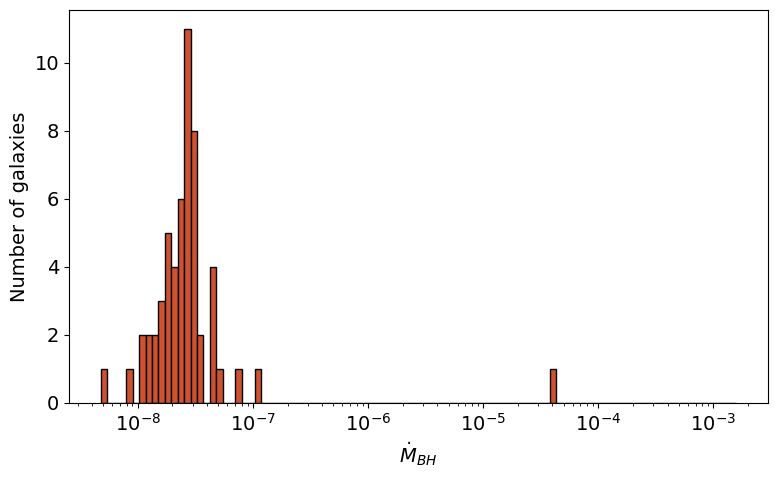

In [48]:
nonzero_mdot = mdot[mdot != 0]

# --- Histogram with log-scaled x-axis ---
plt.figure(figsize=(8,5))
plt.hist(nonzero_mdot, bins=np.logspace(np.log10(nonzero_mdot.min()),
                                           np.log10(nonzero_mdot.max()), 100),
         edgecolor="black",
         facecolor="#cf5230")
plt.xscale("log")
plt.xlabel(r"$\dot{M}_{BH}$")
plt.ylabel("Number of galaxies")
plt.tight_layout()
plt.show()

In [60]:
L_bol = 0.1 * (nonzero_mdot * 1.9891e33 / 3.154e+7) * (3e8)**2 # erg/s

print(L_bol)

[8.94564868e+38 2.43747968e+37 6.49538089e+34 1.04367277e+34
 1.35026676e+34 9.34209970e+33 1.06416238e+34 1.14368950e+34
 1.26264411e+34 1.75559920e+34 1.83707913e+34 1.90890014e+34
 1.52956899e+34 1.57380325e+34 1.30622031e+34 1.20705275e+34
 9.30156274e+33 1.81998628e+34 2.70669060e+33 1.76432947e+34
 1.42922759e+34 1.63821853e+34 8.40684122e+33 1.42610338e+34
 1.62847556e+34 7.52055413e+33 2.57907185e+34 6.42220900e+33
 4.24807858e+34 2.45821733e+34 1.56894925e+34 1.56264709e+34
 1.49121942e+34 1.46532427e+34 2.63279838e+34 8.58233092e+33
 1.50392449e+34 1.28040019e+34 1.75719221e+34 1.57397467e+34
 1.10422166e+34 1.94120291e+34 1.21255818e+34 1.71736009e+34
 7.35774901e+33 5.09383274e+33 9.00035731e+33 2.53372192e+34
 6.56767925e+33 1.07099803e+34 1.51206423e+34 1.77479726e+34
 1.35138929e+34 2.78424510e+33 2.78922494e+34 1.03694094e+34
 1.57713361e+34]


In [66]:
# Solar luminosity in ergs/s
L_sun = 3.828e33 

def bolometric_corrections(L_bol):
    """
    Calculates the mean luminosity and dispersion (scatter) for different 
    quasar luminosity bands based on the model from Shen et al. (2020), Table 1.

    Args:
        L_bol (float): Bolometric luminosity in ergs/s.

    Returns:
        dict: A dictionary containing the dispersed luminosities for each band.
    """
    
    log_L_bol = np.log10(L_bol)
    
    # Bolometric Correction Parameters 
    c1_b, k1_b, c2_b, k2_b = 3.759, -0.361, 9.830, -0.0063
    c1_uv, k1_uv, c2_uv, k2_uv = 1.862, -0.361, 4.870, -0.0063
    c1_xray_soft, k1_xray_soft, c2_xray_soft, k2_xray_soft = 5.712, -0.026, 17.67, 0.278
    c1_xray_hard, k1_xray_hard, c2_xray_hard, k2_xray_hard = 4.073, -0.026, 12.60, 0.278
    c1_ir, k1_ir, c2_ir, k2_ir = 4.361, -0.361, 11.40, -0.0063
    
    # Dispersion Parameters
    sigma1_b, sigma2_b, log_L0_b, sigma3_b = -0.383, 0.405, 42.39, 2.378
    sigma1_uv, sigma2_uv, log_L0_uv, sigma3_uv = -0.372, 0.405, 42.31, 2.310
    sigma1_xray_soft, sigma2_xray_soft, log_L0_xray_soft, sigma3_xray_soft = 0.080, 0.180, 44.16, 1.496
    sigma1_xray_hard, sigma2_xray_hard, log_L0_xray_hard, sigma3_xray_hard = 0.193, 0.066, 42.99, 1.883
    sigma1_ir, sigma2_ir, log_L0_ir, sigma3_ir = -0.338, 0.407, 42.16, 2.193

    # Mean Luminosity Calculations
    L_b_mean = L_bol / (c1_b * (L_bol / (L_sun * 10**10))**k1_b + c2_b * (L_bol / (L_sun * 10**10))**k2_b)
    L_uv_mean = L_bol / (c1_uv * (L_bol / (L_sun * 10**10))**k1_uv + c2_uv * (L_bol / (L_sun * 10**10))**k2_uv)
    L_xray_soft_mean = L_bol / (c1_xray_soft * (L_bol / (L_sun * 10**10))**k1_xray_soft + c2_xray_soft * (L_bol / (L_sun * 10**10))**k2_xray_soft)
    L_xray_hard_mean = L_bol / (c1_xray_hard * (L_bol / (L_sun * 10**10))**k1_xray_hard + c2_xray_hard * (L_bol / (L_sun * 10**10))**k2_xray_hard)
    L_ir_mean = L_bol / (c1_ir * (L_bol / (L_sun * 10**10))**k1_ir + c2_ir * (L_bol / (L_sun * 10**10))**k2_ir)
    
    # Dispersion Calculations for each band
    scatter_b = ((sigma1_b + sigma2_b) / 2 + (sigma1_b - sigma2_b) / 2 * erf((log_L_bol - log_L0_b) / (np.sqrt(2) * sigma3_b)))
    scatter_uv = ((sigma1_uv + sigma2_uv) / 2 + (sigma1_uv - sigma2_uv) / 2 * erf((log_L_bol - log_L0_uv) / (np.sqrt(2) * sigma3_uv)))
    scatter_xray_soft = ((sigma1_xray_soft + sigma2_xray_soft) / 2 + (sigma1_xray_soft - sigma2_xray_soft) / 2 * erf((log_L_bol - log_L0_xray_soft) / (np.sqrt(2) * sigma3_xray_soft)))
    scatter_xray_hard = ((sigma1_xray_hard + sigma2_xray_hard) / 2 + (sigma1_xray_hard - sigma2_xray_hard) / 2 * erf((log_L_bol - log_L0_xray_hard) / (np.sqrt(2) * sigma3_xray_hard)))
    scatter_ir = ((sigma1_ir + sigma2_ir) / 2 + (sigma1_ir - sigma2_ir) / 2 * erf((log_L_bol - log_L0_ir) / (np.sqrt(2) * sigma3_ir)))

    # Apply dispersion to mean luminosities (in log space)
    L_b_dispersed = 10**(np.log10(L_b_mean) + np.random.normal(0, scatter_b))
    L_uv_dispersed = 10**(np.log10(L_uv_mean) + np.random.normal(0, scatter_uv))
    L_xray_soft_dispersed = 10**(np.log10(L_xray_soft_mean) + np.random.normal(0, scatter_xray_soft))
    L_xray_hard_dispersed = 10**(np.log10(L_xray_hard_mean) + np.random.normal(0, scatter_xray_hard))
    L_ir_dispersed = 10**(np.log10(L_ir_mean) + np.random.normal(0, scatter_ir))

    return {
        'L_b': L_b_dispersed,
        'L_uv': L_uv_dispersed,
        'L_xray_soft': L_xray_soft_dispersed,
        'L_xray_hard': L_xray_hard_dispersed,
        'L_ir': L_ir_dispersed
    }
    
calculated_luminosities = bolometric_corrections(L_bol[1])
print(calculated_luminosities['L_b'])
    
    

1.4420065054667144e+35


In [146]:
def luminosity_function(band_luminosities, survey_volume, nbins=12, logL_range=None):
    
    """
    Compute a luminosity function using the classical (non-weighted) method.
    Returns Phi in units of Mpc^-3 dex^-1.
    """

    L = np.asarray(band_luminosities)

    # Default logL range
    if logL_range is None:
        logL_min = np.log10(L.min()) - 0.1
        logL_max = np.log10(L.max()) + 0.1
        logL_range = (logL_min, logL_max)

    logL_bins = np.linspace(logL_range[0], logL_range[1], nbins + 1)
    bin_centers = 0.5 * (logL_bins[:-1] + logL_bins[1:])

    counts, _ = np.histogram(np.log10(L), bins=logL_bins)

    bin_width = np.diff(logL_bins) # should all be equal (dex)
    phi = counts / (survey_volume * bin_width)
    phi_err = np.sqrt(counts) / (survey_volume * bin_width)
    
    # Assign NaN where counts are zero
    nonzero = counts > 0
    phi[nonzero] = counts[nonzero] / (survey_volume * bin_width[0])
    phi_err[nonzero] = np.sqrt(counts[nonzero]) / (survey_volume * bin_width[0])
    phi[~nonzero] = np.nan
    phi_err[~nonzero] = np.nan

    return bin_centers, phi, phi_err, counts

In [147]:
def plot_all_band_lfs(L_bol_array, survey_volume, nbins=12):
    band_map = {
    "B-band": "L_b",
    "UV": "L_uv",
    "X-ray (soft)": "L_xray_soft",
    "X-ray (hard)": "L_xray_hard",
    "IR": "L_ir",
    }

    band_colors = {
    "B-band": "#750202",
    "UV": "#a25016",
    "X-ray (soft)": "#daa520",
    "X-ray (hard)": "#556e37",
    "IR": "#116163",
    }

    band_luminosities = {band: [] for band in band_map}

    for L_bol in L_bol_array:
        band_lums = bolometric_corrections(L_bol)  # should return dict with all bands
        for band, key in band_map.items():
            band_luminosities[band].append(band_lums[key])

    # Convert to arrays
    for band in band_luminosities:
        band_luminosities[band] = np.array(band_luminosities[band])

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, (band, L_vals) in enumerate(band_luminosities.items()):
        logL_centers, phi, phi_err, counts = luminosity_function(L_vals, survey_volume, nbins=nbins)
        ax = axes[i]
        #ax.errorbar(10**logL_centers, phi, yerr=phi_err, fmt="o", color=band_colors[band], lw=4, ls='-')
        ax.plot(10**logL_centers, phi, color=band_colors[band], lw=4, ls='-')
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("L (erg/s)")
        ax.set_ylabel(r"$\Phi(L)$ [Mpc$^{-3}$ dex$^{-1}$]")
        ax.set_title(band)
        ax.set_ylim(bottom=1e-6)

    # Hide the extra subplot
    axes[-1].axis("off")
    plt.tight_layout()
    plt.show()

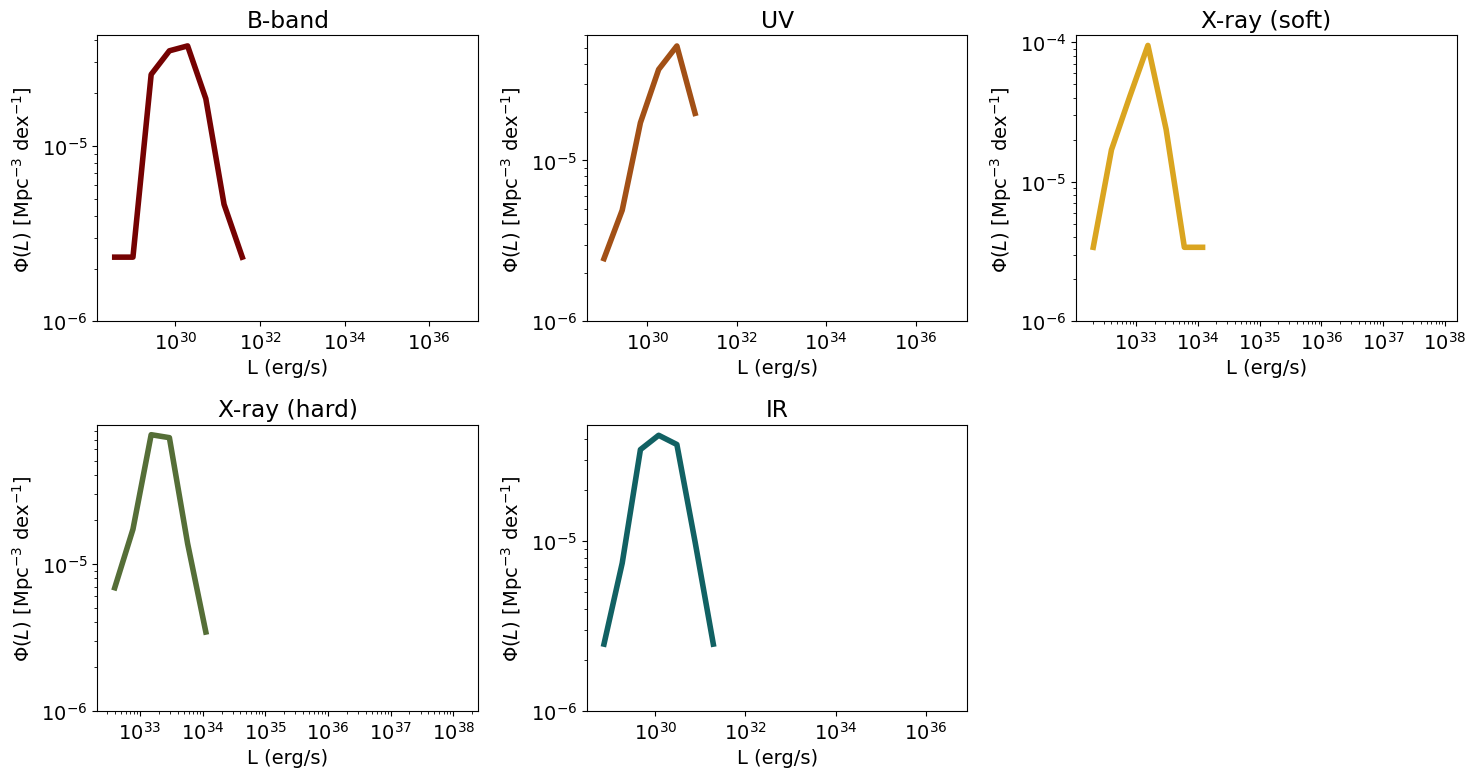

In [148]:
# This needs replacing with the actual volumes
vmax_array = np.full(len(L_bol), 100**3)

plot_all_band_lfs(L_bol, 100**3, nbins=20)